### Multidimensional GP

Until now, our examples have been of 1-dimensional Gaussian processes, where there is just a single predictor variable thought to have a non-linear relationship to the outcome. Let's look at a real-world dataset that involves two predictors. We will use the famous **Walker Lake dataset (Isaaks & Srivistava 1989)** that involves spatial sampling of minerals and other variables over space. The data consist of two spatial coordinates and three measured outcomes. The outcomes are anonymously labeled as U, V (continuous variables, such as concentrarion) and T (discrete variable, such as the presence of a particular element). 

In [1]:
import os

os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

In [3]:
walker_data = pd.read_table('../data/walker.txt', sep='\s+', index_col=0, skiprows=8, header=None, 
              names=['ID', 'Xloc', 'Yloc', 'V', 'U', 'T'])
walker_data.head()

,Xloc,Yloc,V,U,T
ID,,,,,
1,11,8,0.0,1.000000e+31,2
2,8,30,0.0,1.000000e+31,2
3,9,48,224.4,1.000000e+31,2
4,8,69,434.4,1.000000e+31,2
5,9,90,412.1,1.000000e+31,2


The samples are taken regularly over a coarse grid across the entire area, and then irregularly over portions of the area, presumably where there were positive samples on the coarser grid. 

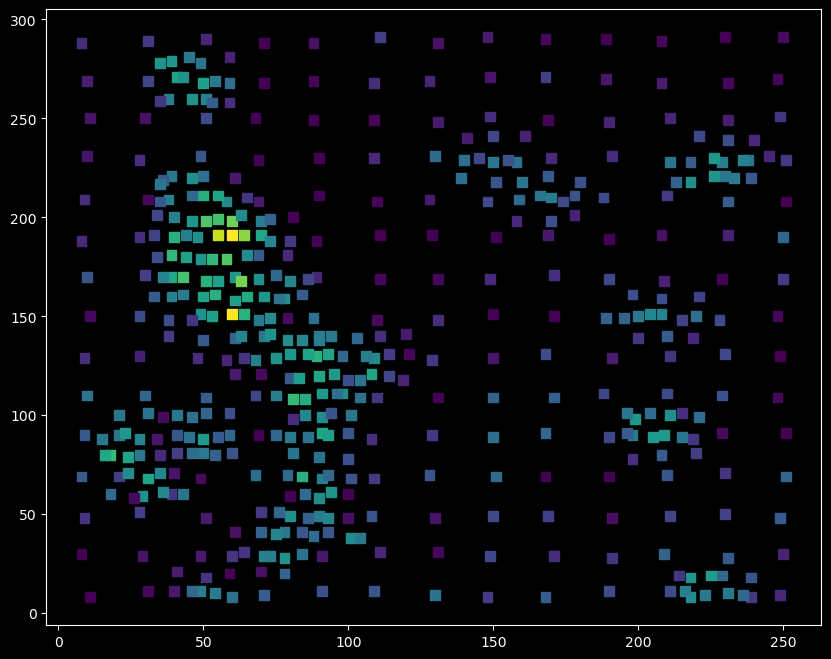

In [7]:
nx = 40
x1, x2 = np.meshgrid(np.linspace(0,300,nx), np.linspace(0,300,nx))
X = np.concatenate([x1.reshape(nx*nx, 1), x2.reshape(nx*nx, 1)], 1)

X_obs = walker_data[['Xloc', 'Yloc']].values
y_obs = walker_data.V.values

plt.figure(figsize=(10,8))
plt.scatter(X_obs[:,0], X_obs[:,1], s=50, c=y_obs, marker='s', cmap=plt.cm.viridis);

We need a sparse grid of inducing points:

In [8]:
nd = 15
xu1, xu2 = np.meshgrid(np.linspace(0, 300, nd), np.linspace(0, 300, nd))
Xu = np.concatenate([xu1.reshape(nd*nd, 1), xu2.reshape(nd*nd, 1)], 1)

In [9]:
with pm.Model() as spatial_model:
    
    l = pm.HalfCauchy("l", beta=3, shape=(2,))
    sf2 = pm.HalfCauchy("sf2", beta=3)
    sn2 = pm.HalfCauchy("sn2", beta=3)

    K = pm.gp.cov.ExpQuad(2, l) * sf2**2
    
    gp_spatial = pm.gp.MarginalSparse(cov_func=K, approx="FITC")
    obs = gp_spatial.marginal_likelihood("obs", X=X_obs, Xu=Xu, y=y_obs, noise=sn2)

    mp = pm.find_MAP()

Output()

In [10]:
nd = 30
z1, z2 = np.meshgrid(np.linspace(0, 300, nd), np.linspace(0, 300, nd))
Z = np.concatenate([z1.reshape(nd*nd, 1), z2.reshape(nd*nd, 1)], 1)

In [13]:
with spatial_model:

    #f_pred = gp_spatial.conditional('f_pred', Z)
    
    samples = pm.sample_posterior_predictive([mp], var_names=['f_pred'])

Sampling: [f_pred]


Output()

In [17]:
samples.posterior_predictive['f_pred'][0]

<xarray.DataArray 'f_pred' (draw: 1, f_pred_dim_2: 900)> Size: 7kB
array([[ 2.30728628e+02, -7.96378382e+01, -6.29210708e+02,
        -4.80593516e+02,  3.04038207e+02,  9.42129150e+02,
         6.25958118e+02,  2.72225862e+02,  4.92320633e+02,
         3.94375152e+02,  1.20660446e+02,  7.91144259e+01,
         5.37867407e+02,  5.13355718e+02, -1.83393368e+02,
         2.21920342e+02,  4.16664211e+02,  7.05772498e+02,
         5.47319392e+02,  2.52702318e+02,  4.69873115e+02,
         5.65782693e+02,  4.71704142e+02,  1.77428213e+02,
         4.22673608e+01, -1.49253147e+01,  7.50284695e+01,
         1.08289682e+01,  5.88979977e+02,  8.63536067e+02,
        -2.37825647e+02, -2.35399423e+02, -3.70449903e+02,
        -1.96182452e+02,  1.91576053e+02,  5.78577839e+02,
         6.17825185e+02,  3.07900531e+02,  5.57667064e+02,
         8.27332928e+02,  3.14310225e+02,  1.77031656e+02,
         7.55933770e+02,  3.04776174e+02, -2.42800189e+02,
         2.26952236e+02,  4.80098019e+02,  5.90578026e+02,
         2.69023622e+02,  6.81811405e+01,  2.15219850e+02,
         3.75047776e+02,  4.90007982e+02,  8.19800771e+02,
         4.58327204e+02, -1.52758961e+02, -2.37679338e+02,
        -2.98622388e+02, -2.33737864e+01,  1.45613060e+02,
...
         4.28954992e+02,  4.08989428e+02,  4.80337851e+02,
         7.91342607e+02,  6.20737965e+02,  6.08473449e+02,
         2.73588927e+02, -2.86187399e+02, -5.62029741e+01,
         6.70114975e+01,  4.77571662e+01, -7.18302421e+01,
         1.03253903e+02,  9.38786370e+01, -1.74230874e+02,
        -2.00280388e+02, -1.02868404e+01,  6.41042278e+01,
        -1.42505644e+02, -2.23514406e-01,  2.49750034e+02,
         5.24978338e+02,  6.07096096e+02,  2.47166599e+02,
        -3.22327356e+02,  4.45759856e+01,  5.56148247e+02,
         3.22237026e+02,  3.35384037e+02,  5.58250141e+02,
        -2.49728690e+02,  1.09848597e+02,  5.54735923e+02,
         6.92628495e+02,  2.42566889e+02,  4.17028509e+01,
         1.62992731e+02, -4.43150801e+01, -2.13697086e+02,
        -3.19117909e+02, -1.61388535e+02, -2.09333987e+02,
        -1.36294306e+02,  1.46329998e+02, -2.57223273e+02,
        -3.29101864e+02, -2.87778020e+02, -2.76647854e+01,
        -9.33564007e+01, -3.65717083e+02, -7.21284871e+01,
         2.26666959e+02,  4.27939233e+02,  9.86685158e+01,
        -4.06378655e+02, -1.20830361e+02,  7.16480419e+02,
         7.48539826e+02,  6.12275049e+02,  2.77118904e+02]])
Coordinates:
    chain         int64 8B 0
  * draw          (draw) int64 8B 0
  * f_pred_dim_2  (f_pred_dim_2) int64 7kB 0 1 2 3 4 5 ... 895 896 897 898 899

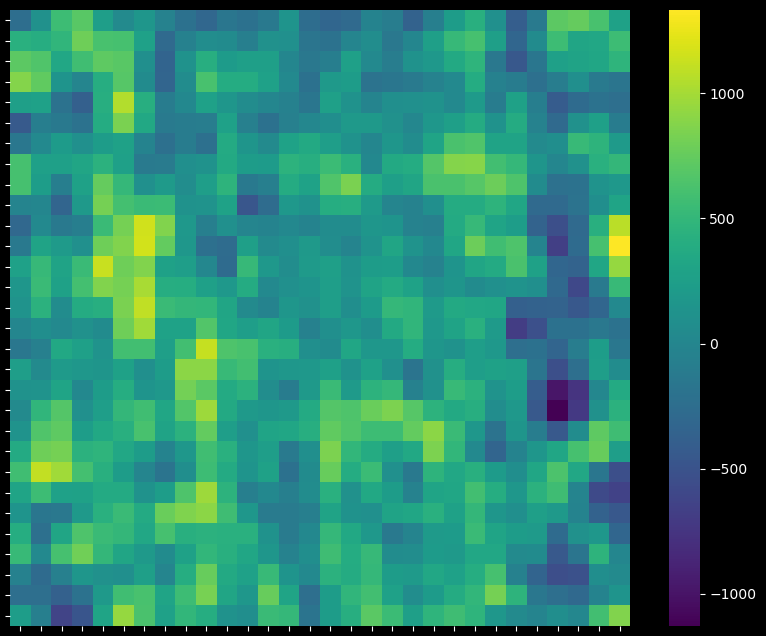

In [19]:
plt.figure(figsize=(10,8))
ax = sns.heatmap(samples.posterior_predictive['f_pred'][0].to_numpy().mean(0).reshape(nd, nd), cmap='viridis')
ax.invert_yaxis()
ax.set_yticklabels([])
ax.set_xticklabels([]);